# Introduction to Computer Vision

So you have learned how to manipulate matrices with numpy and some basic image processing with scikit-image processing package. 

Today we would look into OpenCV (Open source Computer Vision library), use it for a couple of cool image processing application and than demonstrate how to use it for a  computer vision applications.

First we import necessary libraries

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

You have to install OpenCV-Python version using 

> `pip install opencv-python` 
or 
> `pip install opencv-contrib-python`

Run these commands on your terminal or if you are using Anaconda Navigator – Jupyter Notebook, you can change “pip” with the “conda” command and install the same.

A detailed overview for opencv [installation](https://docs.opencv.org/master/d0/d3d/tutorial_general_install.html) is provided. You could also get useful information for [python installation](https://pypi.org/project/opencv-python/) here.

It also has extensive [documentation](https://docs.opencv.org/master/) and [tutorials](https://docs.opencv.org/master/d9/df8/tutorial_root.html)

## Importing the Open-CV library

In [2]:
import cv2

There exist a nice utility library `imutils` which can help you get OpenCV parameters and function names even from partial strings

In [3]:
import imutils
imutils.find_function('read')

1. ACCESS_READ
2. FILE_STORAGE_READ
3. FileStorage_READ
4. IMREAD_ANYCOLOR
5. IMREAD_ANYDEPTH
6. IMREAD_COLOR
7. IMREAD_GRAYSCALE
8. IMREAD_IGNORE_ORIENTATION
9. IMREAD_LOAD_GDAL
10. IMREAD_REDUCED_COLOR_2
11. IMREAD_REDUCED_COLOR_4
12. IMREAD_REDUCED_COLOR_8
13. IMREAD_REDUCED_GRAYSCALE_2
14. IMREAD_REDUCED_GRAYSCALE_4
15. IMREAD_REDUCED_GRAYSCALE_8
16. IMREAD_UNCHANGED
17. getNumThreads
18. getThreadNum
19. haveImageReader
20. imread
21. imreadmulti
22. readOpticalFlow
23. setNumThreads
24. startWindowThread


For detailed description, you could always rely on `help`

In [4]:
help(cv2.imread)

Help on built-in function imread:

imread(...)
    imread(filename[, flags]) -> retval
    .   @brief Loads an image from a file.
    .   
    .   @anchor imread
    .   
    .   The function imread loads an image from the specified file and returns it. If the image cannot be
    .   read (because of missing file, improper permissions, unsupported or invalid format), the function
    .   returns an empty matrix ( Mat::data==NULL ).
    .   
    .   Currently, the following file formats are supported:
    .   
    .   -   Windows bitmaps - \*.bmp, \*.dib (always supported)
    .   -   JPEG files - \*.jpeg, \*.jpg, \*.jpe (see the *Note* section)
    .   -   JPEG 2000 files - \*.jp2 (see the *Note* section)
    .   -   Portable Network Graphics - \*.png (see the *Note* section)
    .   -   WebP - \*.webp (see the *Note* section)
    .   -   Portable image format - \*.pbm, \*.pgm, \*.ppm \*.pxm, \*.pnm (always supported)
    .   -   PFM files - \*.pfm (see the *Note* section)
    .   -   

## Gradient Domain Image Manipulation

As you have already learned in the computer vision lecture, gradient based operators operate on the gradient between neighboring pixels rather than the pixel value itself.

The goal of gradient domain image manipulation is to construct a new image which minimizes the divergence of image gradients between the images.

This is generally done by solving a Poisson equation [1] 
$$\triangledown^2 I = div(G)$$
 which we are not going into detail but we would use to composite two images

[1] Patrick Pérez, Michel Gangnet, and Andrew Blake. Poisson image editing. In ACM Transactions on Graphics (TOG), volume 22, pages 313–318. ACM, 2003.

## Image Compositing

Compositing an image is a common task in image editing in which some or all of one image is pasted into the another image.

First we load both images, for this you  could use a familiar function  i.e imread that you used in scikit to load the images

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
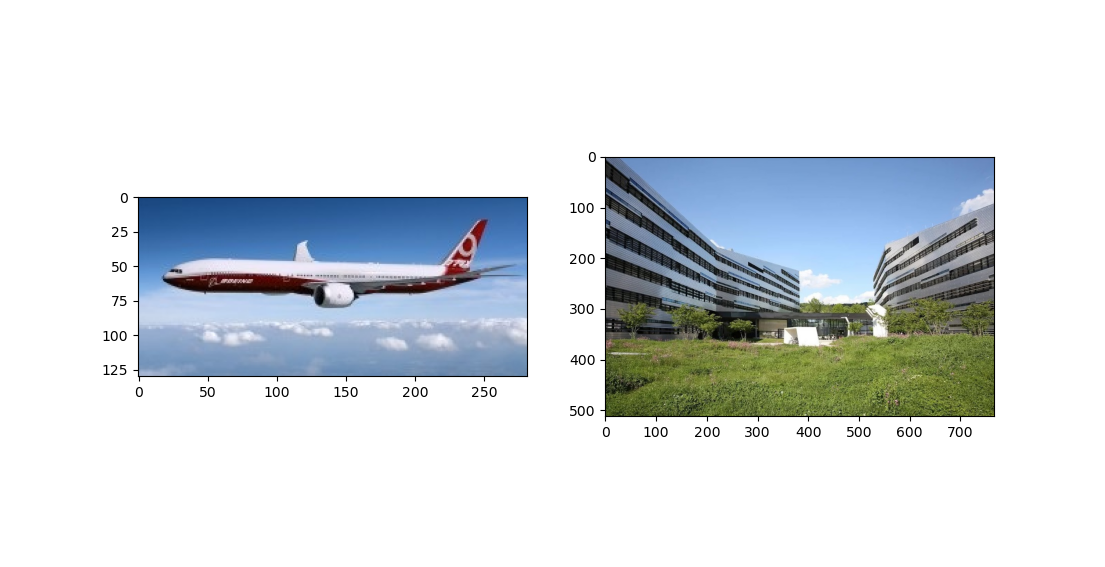

In [5]:
# Read images
src = cv2.cvtColor(cv2.imread("aeroplane2.jpg"),cv2.COLOR_BGR2RGB) ##Read images using imread function and convert color space using cvtColor
dst = cv2.cvtColor(cv2.imread("sp3.jpg"),cv2.COLOR_BGR2RGB)
resultdst = dst.copy()
#display settings
margin=10 # pixels
spacing =35 # pixels
dpi=100. # dots per inch

width = (src.shape[1]+dst.shape[1]+2*margin+spacing)/dpi # inches
height= (max(src.shape[0],dst.shape[0])+2*margin+spacing)/dpi

fig, ax = plt.subplots(1,2, figsize=(width,height), dpi=dpi)
ax[0].imshow(src)
ax[1].imshow(dst)

After loading the images we take help of the matplotlib `PolygonSelector` function to create a mask to separate the object from the image which we want to add to the new image.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
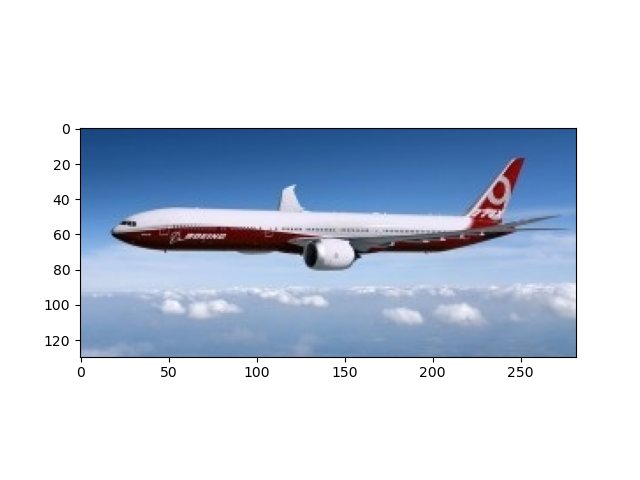

In [6]:
from matplotlib.widgets import PolygonSelector
def finished(x):
    print("Selected points:", x)
    plt.close(fig)
selectpolygon = False
fig, ax = plt.subplots()
ax.imshow(src)
if selectpolygon:
    ps = PolygonSelector(ax, onselect=finished) #return points from the polygon selecter

After selecting the vertices of the polygon defining the mask, we now generate a binary mask containing the selected object

(130, 282, 3)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
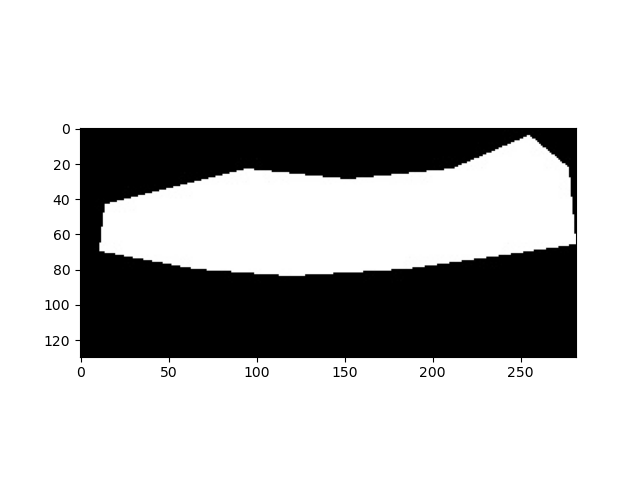

In [7]:
if selectpolygon:
    points = np.array(ps.verts).astype(np.int32) #convert polygon point vertices to integer array
    mask = np.zeros(src.shape, src.dtype)
    cv2.fillPoly(mask, [points], (255, 255, 255)) #fill polygon with white color
else :
    mask = cv2.imread("aeroplane2_mask.jpg") #if polygon selector is not working for some reason load a predefined mask
print(mask.shape)
fig, ax = plt.subplots()
plt.imshow(mask)

First, we would do a naive image editing based on a mask

Note that in OpenCV you could still acces each pixel of the image as image_name.at(row,column).

However, when you describe a point in OpenCV you need to describe as Point_name(column, row)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
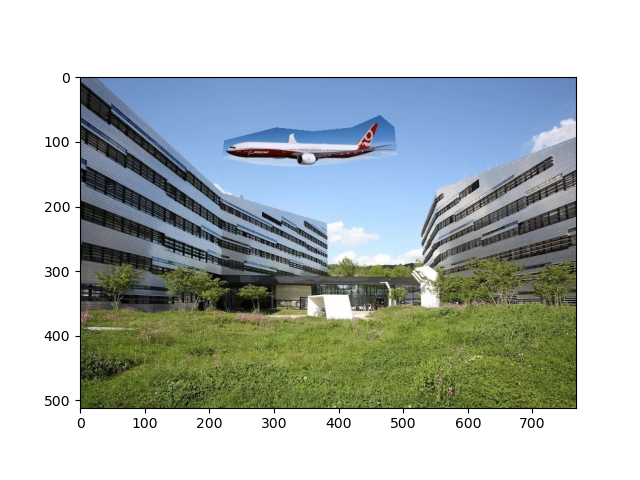

In [8]:
src_mask = cv2.normalize(mask.astype('float'), None, 0.0, 1.0, norm_type=cv2.NORM_MINMAX) #normalize the mask to be between 1 and 0
pos = (350,120) # position on the dst image where the object from source image needs to be edited-- (column,row) --- since input to OpenCV require it in this format
halfwidth = (int(src_mask.shape[0]/2),int(src_mask.shape[1]/2)) #calculate mask half width
###Remember in OpenCV  src.at(i,j) is using (i,j) as (row,column) but Point(x,y) is using (x,y) as (column,row)
resultdst[pos[1]-halfwidth[0]:pos[1]+halfwidth[0],pos[0]-halfwidth[1]:pos[0]+ halfwidth[1],:] = dst[pos[1]- halfwidth[0]:pos[1]+halfwidth[0],pos[0]-halfwidth[1]:pos[0]+halfwidth[1],:] * (1 - src_mask) + src * src_mask
fig, ax = plt.subplots()
plt.imshow(resultdst)

As you could see this is not a very good image editing. 

You could clearly see the seams that is present where you added two different images.

Next we will see how this could be done more efficiently by using gradient image manipulation.

OpenCV has a very simple implementation to achieve this.
We will use the `seamlessClone` function to add the masked object onto the source image. This function implements poisson image blending presented in [1]. 

However, this is not a very efficient implementation and I hope that you would try to implement a better one for the Bonus task.

True

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
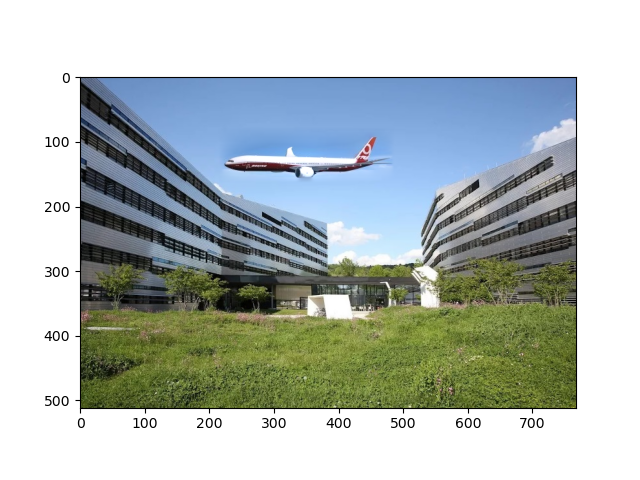

In [9]:
# Clone seamlessly
output = cv2.seamlessClone(src, dst, mask, pos, cv2.MIXED_CLONE)

### Poisson blending -- implement yourself
# Save result
fig, ax = plt.subplots()
plt.imshow(output)
cv2.imwrite("opencv_gradientdomain_imagemanipulation.png", output)

## Image Segmentation

Defining a better mask for segmenting an object in an image is a time consuming and tedious process.

Next we would see how we can use 'Grabcut', a graph based image segmentation algorithm which would do the heavy lifting  of creating a segmentation mask for us.

Here, you just define a rectangle containing all objects to be segmented in the image.

For this we would take help of matplotlib `RectanlgeSelector`function


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
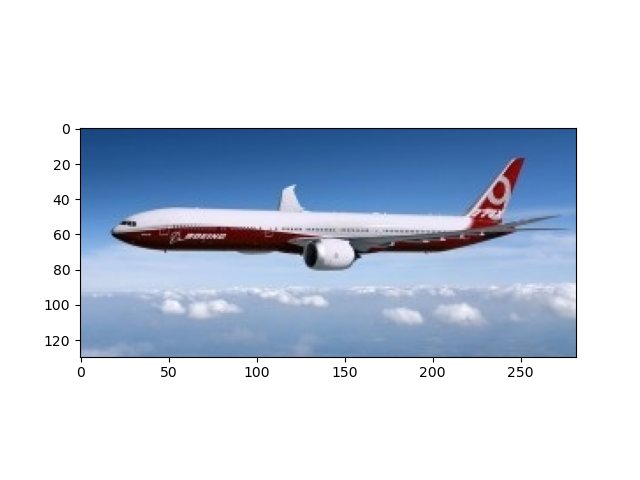

In [10]:
from matplotlib.widgets import RectangleSelector
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    global x1, y1, x2, y2
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    print(" The button you used were: %s %s" % (eclick.button, erelease.button))

def toggle_selector(event):
    print(' Key pressed.')
    if event.key == 't':
        if toggle_selector.RS.active:
            print(' RectangleSelector deactivated.')
            toggle_selector.RS.set_active(False)
        else:
            print(' RectangleSelector activated.')
            toggle_selector.RS.set_active(True)
# ============================================================================

##Select object to be segmented, select a rectangle around the object
##everything else in the image becomes background
fig, current_ax = plt.subplots()
plt.imshow(src)
RectangleSelection = False
if RectangleSelection:
    toggle_selector.RS = RectangleSelector(current_ax, line_select_callback,
                                        drawtype='box', useblit=True,
                                        button=[1, 3],  # don't use middle button
                                        minspanx=5, minspany=5,
                                        spancoords='pixels',
                                        interactive=True)
    plt.connect('key_press_event', toggle_selector)


The algorithm does an initial labelling based on the provided mask. It labels the foreground and background pixels.

Now a Gaussian Mixture Model(GMM) is used to model the foreground and background.

GMM learns and create new pixel distribution, i.e the unknown pixels are labelled either probable foreground or probable background.

Its done depending on its relation with the other hard-labelled pixels in terms of color statistics (it is just like clustering).

A graph is built from this pixel distribution. 
Nodes in the graphs are pixels. 

Additional two nodes are added, Source node and Sink node. Every foreground pixel is connected to Source node and every background pixel is connected to Sink node.

The weights of edges connecting pixels to source node/end node are defined by the probability of a pixel being foreground/background. 

The weights between the pixels are defined by the edge information or pixel similarity. 

If there is a large difference in pixel color, the edge between them will get a low weight.

Then a mincut algorithm is used to segment the graph. It cuts the graph into two separating source node and sink node with minimum cost function. 

The cost function is the sum of all weights of the edges that are cut. 

After the cut, all the pixels connected to Source node become foreground and those connected to Sink node become background.

The process is continued until the classification converges.

Most cases, this result in very fine Foreground and Background Segmentation.

However if it fails then we just need to fine tune the mask and our image would again be automatically segmented.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
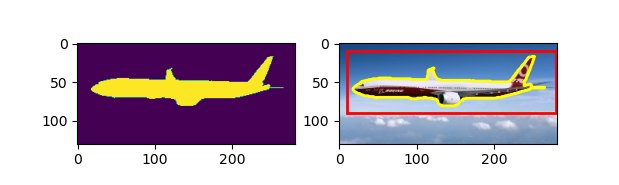

In [11]:
from matplotlib.patches import Rectangle
auto_mask = np.zeros(src.shape[:2],np.uint8) ##intialize a mask image

bgdModel = np.zeros((1,65),np.float64) ##intialize background and foreground model
fgdModel = np.zeros((1,65),np.float64)
if RectangleSelection:
    print(x1, x2, y1, y2)
    rect= (int(x1),int(y1),int(x2-x1),int(y2-y1))
else:
    rect = (10,10,270,80)
### Utilze the OpenCv grab cut function to auto matically segement the object. -- 
### Grab cut utilizes the graph cut algorithm
cv2.grabCut(src,auto_mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((auto_mask==2)|(auto_mask==0),0,1).astype('uint8')
dis_img = mask2[:,:,np.newaxis]
#plt.figure(4)
#plt.imshow(dis_img)
width = (src.shape[1]+dis_img.shape[1]+2*margin+spacing)/dpi # inches
height= (max(src.shape[0],dis_img.shape[0])+2*margin+spacing)/dpi

fig, ax = plt.subplots(1,2, figsize=(width,height), dpi=dpi)
# show image
ax[0].imshow(dis_img)
ax[1].imshow(src)
# define the foreground region
ax[1].add_patch(Rectangle(rect[:2],rect[2], rect[3],linewidth=2,edgecolor='r',facecolor='none'))
# show the mask 
ax[1].contour(mask2, [0.5], colors="yellow", linewidths=2)

# Object Detection

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
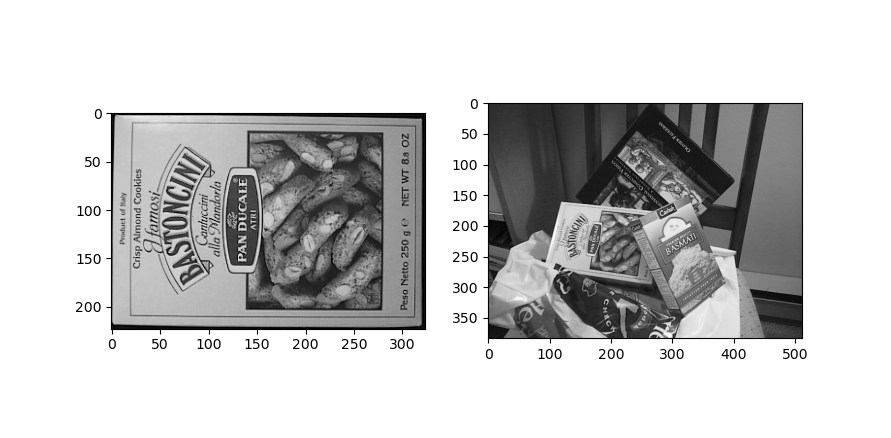

In [12]:

MIN_MATCH_COUNT = 10
## Read Object Image and Image for Object Detection
qry_src = cv2.imread('box.png')          # queryImage
det_src = cv2.imread('box_in_scene.png') # trainImage

width = (qry_src.shape[1]+det_src.shape[1]+2*margin+spacing)/dpi # inches
height= (max(qry_src.shape[0],det_src.shape[0])+2*margin+spacing)/dpi

fig, ax = plt.subplots(1,2, figsize=(width,height), dpi=dpi)
ax[0].imshow(qry_src)
ax[1].imshow(det_src)

Let’s find features in images ( here we use scale-invariant feature transform or SIFT [2]) and apply the ratio test to find the best matches.

[2] Lowe, David G. "Object recognition from local scale-invariant features." Proceedings of the seventh IEEE international conference on computer vision. Vol. 2. Ieee, 1999.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
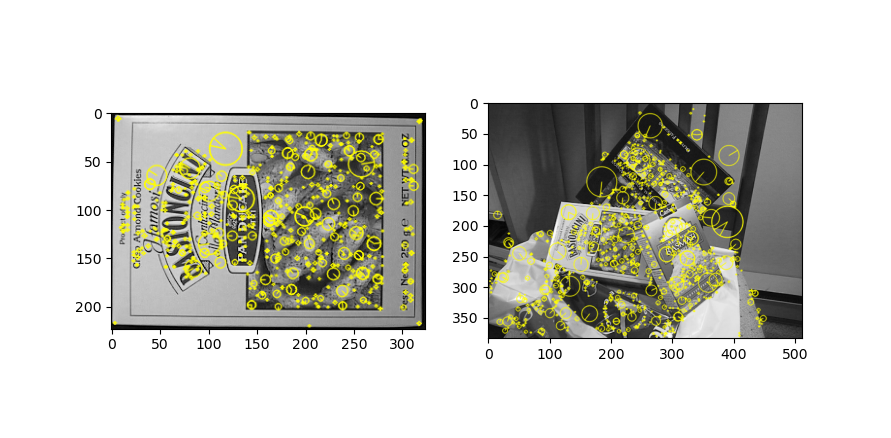

In [13]:
# Initiate SIFT feature Detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(qry_src,None)
kp2, des2 = sift.detectAndCompute(det_src,None)
# Draw keypoints on the image
kp1_img = cv2.drawKeypoints(qry_src, kp1, None, color=(255, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_img = cv2.drawKeypoints(det_src, kp2, None, color=(255, 255, 0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

width = (kp1_img.shape[1]+kp2_img.shape[1]+2*margin+spacing)/dpi # inches
height= (max(kp1_img.shape[0],kp2_img.shape[0])+2*margin+spacing)/dpi

fig, ax = plt.subplots(1,2, figsize=(width,height), dpi=dpi)
ax[0].imshow(kp1_img)
ax[1].imshow(kp2_img)

Next we need to match these features.

For these we use a Fast Library for Approximate Nearest Neighbors (FLANN [3]). 

It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. 

It works more faster than BFMatcher for large datasets. 

For FLANN based matcher, we need to pass two dictionaries which specifies the algorithm to be used, its related parameters etc. 

First one is IndexParams. 

For various algorithms, the information to be passed is explained in FLANN docs.

Second dictionary is the SearchParams. 

It specifies the number of times the trees in the index should be recursively traversed. 

Higher values gives better precision, but also takes more time. 

[3] Muja, Marius, and David G. Lowe. "Fast approximate nearest neighbors with automatic algorithm configuration." VISAPP (1) 2.331-340 (2009): 2.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
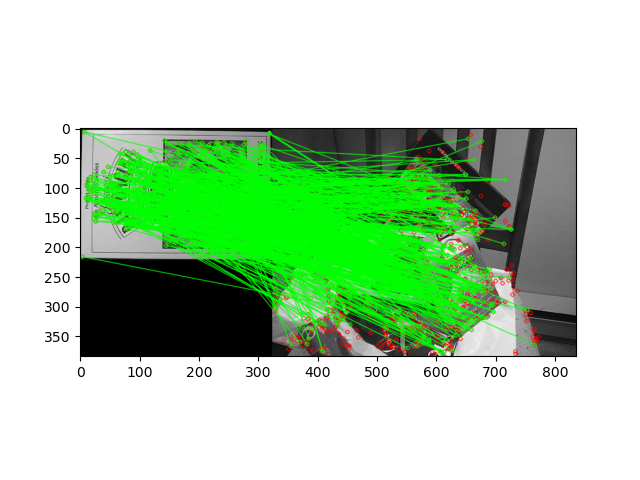

In [14]:
### Inititate Flann based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
matchesMask = [[1,0] for i in range(len(matches))]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
# draw matches
match_img = cv2.drawMatchesKnn(qry_src,kp1,det_src,kp2,matches,None,**draw_params)
fig, ax = plt.subplots()
plt.imshow(match_img)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
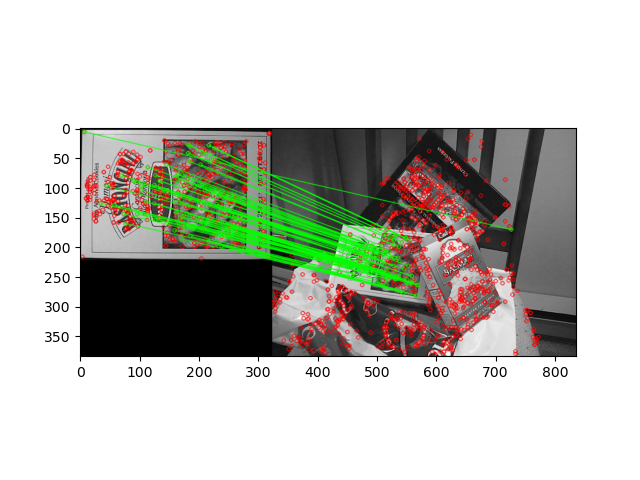

In [15]:
# store all the good matches as per Lowe's ratio test.
good = []
newmatchesMask = [[0,0] for i in range(len(matches))]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = newmatchesMask,
                   flags = 0)
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        newmatchesMask[i]=[1,0]
# draw matches
match_img = cv2.drawMatchesKnn(qry_src,kp1,det_src,kp2,matches,None,**draw_params)
fig, ax = plt.subplots()
plt.imshow(match_img)

Now we set a condition that atleast 10 matches (defined by `MIN_MATCH_COUNT`) are to be there to find the object. 

Otherwise simply show a message saying not enough matches are present.

If enough matches are found, we extract the locations of matched keypoints in both the images. 

They are passed to find the perpective transformation. 

Once we get this 3x3 transformation matrix, we use it to transform the corners of queryImage to corresponding points in trainImage. Then we draw it.

In [16]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,_ = qry_src.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(det_src,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    


Finally we draw our inliers (if successfully found the object) or matching keypoints (if failed).

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
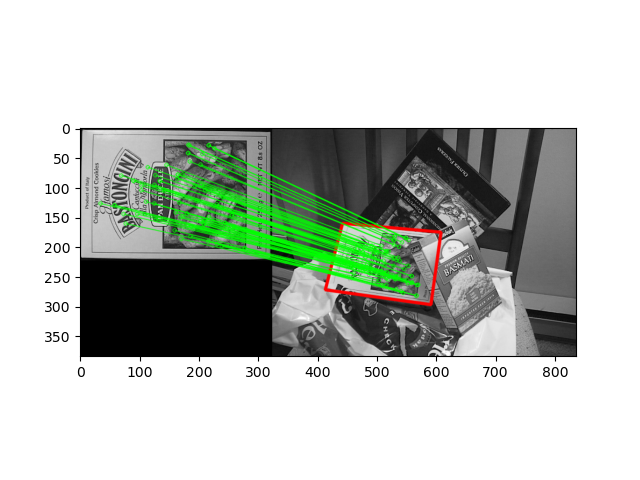

In [17]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
res_img = cv2.drawMatches(qry_src,kp1,det_src,kp2,good,None,**draw_params)
fig, ax = plt.subplots()
plt.imshow(res_img)

# Bonus Task (4%)

## Panorama Stitiching
 1. Take multiple images of an interesting scene from your own camera with sufficient overlapping field of view between these images. Pan your camera through the scene such that multiple images have overlapping field of view however still have different scene content within each image.
 2. Stitch them together to generate a panorama.
 3. Use appropriate blending method to appropriatly blend them together (e.g. Poisson blending, ...).

For further details on panorama stitching, we refer to Brown and Lowe [4]. Note that your solution is only supposed to use functions available in the `numpy`, `skimage`, and `cv2` packages. No worries, your solution does not have to be real-time capable.

[4] Matthew Brown and David G. Lowe. 2007. Automatic Panoramic Image Stitching using Invariant Features. Int. J. Comput. Vision 74, 1 (August 2007), 59-73.

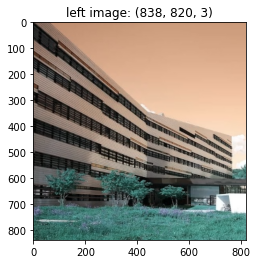

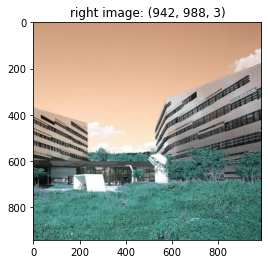

In [90]:
%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
import numpy as np
import cv2

img_left = cv2.imread('t2.png')
img_right = cv2.imread('t2_2.png')


m_l = img_left.shape[0]
n_l = img_left.shape[1]
m_r = img_right.shape[0]
n_r = img_right.shape[1]

plt.imshow(img_left)
plt.title('left image: %s'%str(img_left.shape))
plt.show()
plt.imshow(img_right)
plt.title('right image: %s'%str(img_right.shape))
plt.show()


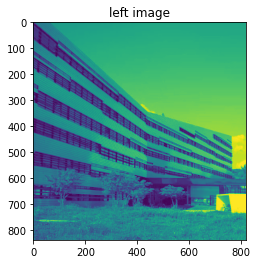

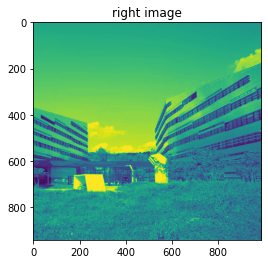

In [91]:
# make gray:
left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
plt.imshow(left_gray)
plt.title('left image')
plt.show()
plt.imshow(right_gray)
plt.title('right image')
plt.show()

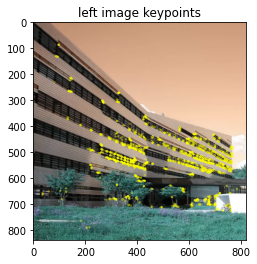

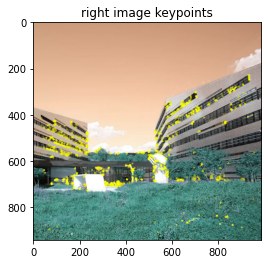

In [92]:
# use ORB of cv2
orb = cv2.ORB_create(nfeatures=2000)
p_l, d_l = orb.detectAndCompute(img_left, None)
p_r, d_r = orb.detectAndCompute(img_right, None)

plt.imshow(cv2.drawKeypoints(image=img_left, 
                             keypoints=p_l, 
                             outImage=None, 
                             color=(255, 255, 0)))
plt.title('left image keypoints')
plt.show()
plt.imshow(cv2.drawKeypoints(image=img_right, 
                             keypoints=p_r, 
                             outImage=None, 
                             color=(255, 255, 0)))
plt.title('right image keypoints')
plt.show()

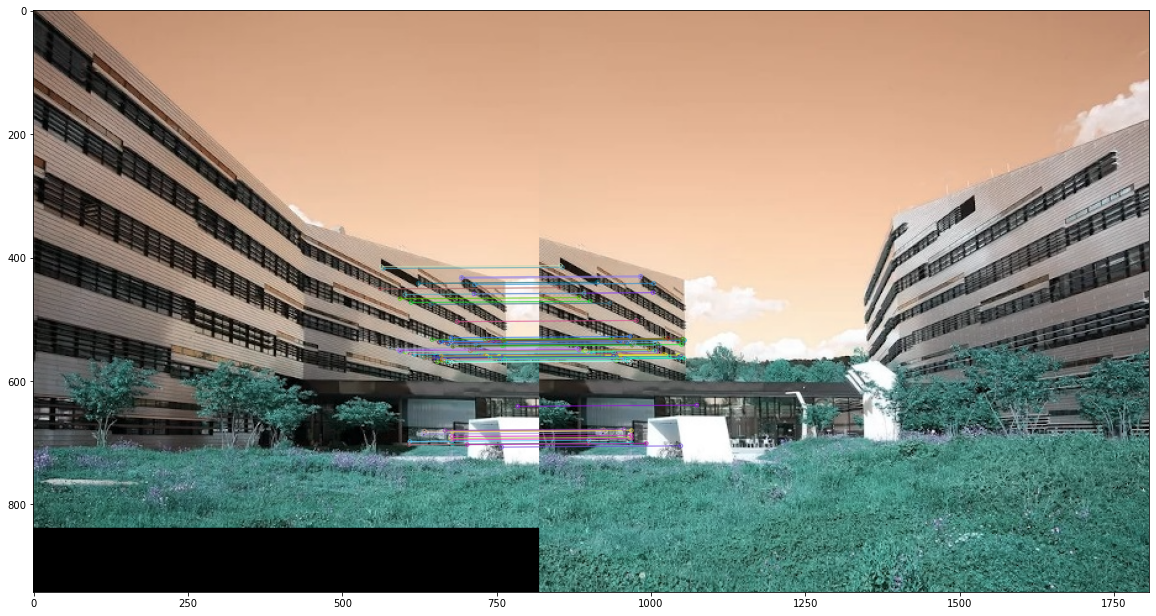

In [93]:
# use BFMatcher

matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING) # for ORB NORM_HAMMING should be used
matched = matcher.match(d_l, d_r)
matched = sorted(matched, key=lambda x: x.distance)
N_best = 77
matches_to_draw = cv2.drawMatches(img_left, p_l, img_right, p_r, 
                                matched[:N_best], None, flags=2)
plt.figure(figsize=(20, 20))
plt.imshow(matches_to_draw)


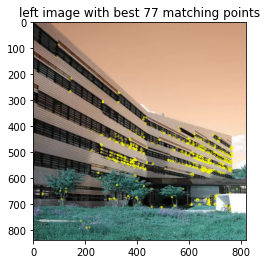

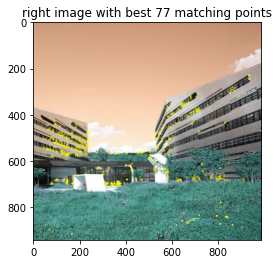

In [94]:
plt.imshow(cv2.drawKeypoints(img_left, 
                             [p_l[i] for i, x in enumerate(matches_to_draw)], 
                             None, 
                             (255, 255, 0)))
plt.title('left image with best %d matching points'%N_best)
plt.show()
plt.imshow(cv2.drawKeypoints(img_right, 
                             [p_r[i] for i, x in enumerate(matches_to_draw)], 
                             None, 
                             (255, 255, 0))) 
plt.title('right image with best %d matching points'%N_best)
plt.show()


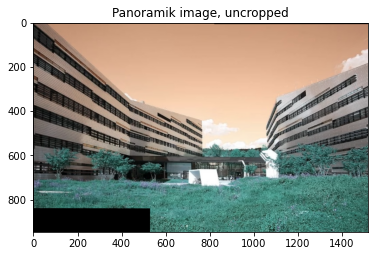

In [95]:
bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)
matches = bf.knnMatch(d_l, d_r, k=2)

good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)
        

src_pts = np.float32([ p_l[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([ p_r[m.trainIdx].pt for m in good]).reshape(-1,1,2)

M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

list_of_points_1 = np.float32([[0, 0], 
                               [0, m_r],
                               [n_r, m_r], 
                               [n_r, 0]]).reshape(-1, 1, 2)
temp_points = np.float32([[0, 0], 
                          [0, m_l], 
                          [n_l, m_l], 
                          [n_l, 0]]).reshape(-1,1,2)

list_of_points_2 = cv2.perspectiveTransform(temp_points, M)

list_of_points = np.concatenate((list_of_points_1,
                                 list_of_points_2), 
                                axis=0)

[x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

translation_dist = [-x_min,-y_min]

H_translation = np.array([[1, 0, translation_dist[0]], 
                          [0, 1, translation_dist[1]], 
                          [0, 0, 1]])

output_img = cv2.warpPerspective(img_left, 
                                 H_translation.dot(M), 
                                 (x_max-x_min, y_max-y_min))
output_img[translation_dist[1]:m_r+translation_dist[1], 
           translation_dist[0]:n_r+translation_dist[0]] = img_right



plt.imshow(output_img)
plt.title('Panoramik image, uncropped')
plt.show()
